In [11]:
% usa l2,l3,l4,l5,l6 y theta1, dtheta1
function [X_pos, X_dot_analytic, X_dot_jac] = kinematics_both(theta1_val, dtheta1_val)
  % parámetros (usar los valores de tu problema)
  l2=45; l3=110; l4=59; l5=58; l6=46;

  % 1) resolver posiciones (usa tu función numérica o fsolve)
  F = @(x)[ l2*cos(theta1_val)- x(1)*cos(x(2));
            l4 + l2*sin(theta1_val) - x(1)*sin(x(2));
            l2*cos(theta1_val) + (l3 - x(1))*cos(x(2)) - l6*cos(x(3)) - x(4);
            l2*sin(theta1_val) + (l3 - x(1))*sin(x(2)) + l6*sin(x(3)) - l5];
  x0 = [100; 1.4; 0.2; -30];
  X_pos = fsolve(F,x0); % X_pos = [d1; theta2; theta3; d7]

  d1 = X_pos(1); th2 = X_pos(2); th3 = X_pos(3); d7 = X_pos(4);

  % -------------------------
  % 2) método analítico (diferenciación de lazo)
  d1_dot = l2 * dtheta1_val * sin(theta1_val - th2);
  th2_dot = (l2 * dtheta1_val * cos(theta1_val - th2)) / d1;

  % RHS para la matriz 2x2 del lazo 2
  rhs1 = l2*dtheta1_val*sin(theta1_val) + d1_dot*cos(th2) + (l3-d1)*th2_dot*sin(th2);
  rhs2 = -l2*dtheta1_val*cos(theta1_val) + d1_dot*sin(th2) - (l3-d1)*th2_dot*cos(th2);

  A = [ l6*sin(th3), -1;
        l6*cos(th3),  0 ];
  sol = A \ [rhs1; rhs2];
  th3_dot = sol(1);
  d7_dot  = sol(2);

  X_dot_analytic = [d1_dot; th2_dot; th3_dot; d7_dot];

  % -------------------------
  % 3) método jacobiano
  Jx = [-cos(th2), d1*sin(th2), 0, 0;
        -sin(th2), -d1*cos(th2), 0, 0;
        -cos(th2), -(l3-d1)*sin(th2), l6*sin(th3), -1;
        -sin(th2), (l3-d1)*cos(th2), l6*cos(th3), 0];

  Jth1 = [-l2*sin(theta1_val);
          l2*cos(theta1_val);
          -l2*sin(theta1_val);
          l2*cos(theta1_val)];

  % resolver Jx * Xdot = -Jth1 * dtheta1_val
  X_dot_jac = - (Jx \ (Jth1 * dtheta1_val));

end


In [12]:
[X_pos, X_dot_analytic, X_dot_jac] = kinematics_both(deg2rad(76), -0.3*pi)

X_pos =

   103.2389
     1.4652
     0.1663
   -33.7662

X_dot_analytic =

    5.8636
   -0.4069
    0.3611
   46.0180

X_dot_jac =

   -5.8636
   -0.4069
    0.1040
   45.2975



In [15]:
abs(X_dot_analytic) - abs(X_dot_jac)

ans =

  -0.0000
        0
   0.2571
   0.7205



In [2]:
graphics_toolkit("gnuplot");



The gnuplot graphics toolkit is not actively maintained and has a number
of limitations that are ulikely to be fixed.  Communication with gnuplot
uses a one-directional pipe and limited information is passed back to the
Octave interpreter so most changes made interactively in the plot window
will not be reflected in the graphics properties managed by Octave.  For
example, if the plot window is closed with a mouse click, Octave will not
be notified and will not update it's internal list of open figure windows.
We recommend using the qt toolkit instead.


Inline plot failed, consider trying another graphics toolkit
error: print: figure must be visible or qt toolkit must be used with __gl_window__ property 'on' or QT_OFFSCREEN feature available
error: called from
    _make_figures>safe_print at line 125 column 7
    _make_figures at line 49 column 13



Resultados con ddtheta1 = -0.942 rad/s^2
Velocidad máxima de P: 333.152 mm/s
Aceleración máxima de P: 1140.409 mm/s²
Aceleración angular máxima theta2: 7.467 rad/s²


Inline plot failed, consider trying another graphics toolkit
error: print: figure must be visible or qt toolkit must be used with __gl_window__ property 'on' or QT_OFFSCREEN feature available
error: called from
    _make_figures>safe_print at line 125 column 7
    _make_figures at line 49 column 13



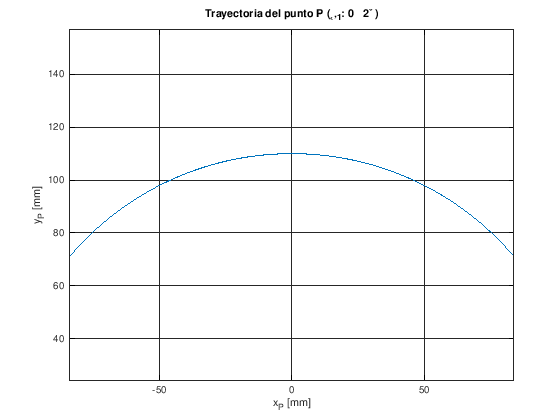

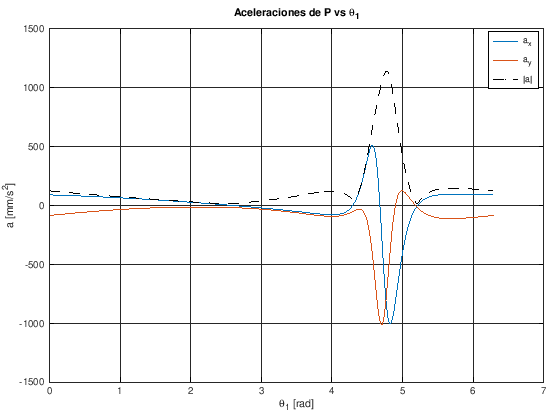

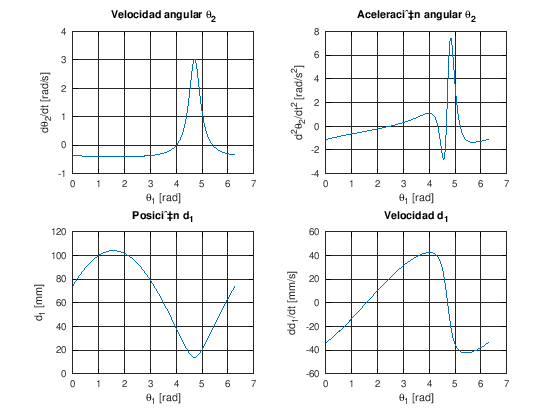

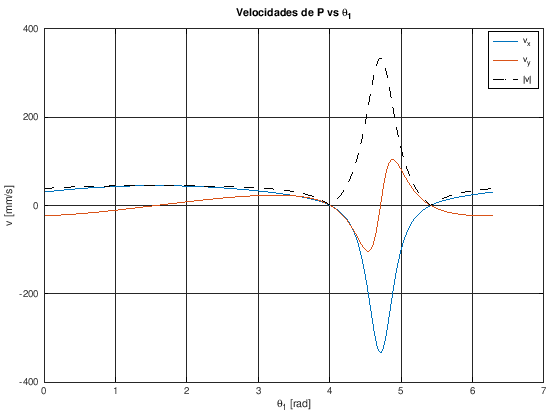

In [3]:
l2 = 45;   % mm
l3 = 110;  % mm
l4 = 59;   % mm
l5 = 58;   % mm
l6 = 46;   % mm

% Entrada CORREGIDA: ddtheta1 = -0.3*pi
dtheta1 = -0.3*pi;   
ddtheta1 = -0.3*pi;      % rad/s^2 (CORREGIDO)

% malla de theta1
N = 400;
theta1_vals = linspace(0, 2*pi, N);

% arrays para resultados
xP = zeros(1,N); yP = zeros(1,N);
vxP = zeros(1,N); vyP = zeros(1,N);
axP = zeros(1,N); ayP = zeros(1,N);
Xpos_store = zeros(4,N); Xdot_store = zeros(4,N); Xddot_store = zeros(4,N);

% tolerancias y guess inicial
x0_guess = [103.2389; 1.4652; 0.1663; -33.7662]; % buen punto inicial (de T6)
opts = optimset('Display','off','TolX',1e-8,'TolFun',1e-8,'MaxIter',200);

for k = 1:N
  theta1 = theta1_vals(k);

  % 1) resolver posiciones: usar formulas cerradas cuando aplicable para
  % estabilidad numérica (aquí usamos fsolve con buen guess)
  F = @(x) [ l2*cos(theta1) - x(1)*cos(x(2));
             l4 + l2*sin(theta1) - x(1)*sin(x(2));
             l2*cos(theta1) + (l3 - x(1))*cos(x(2)) - l6*cos(x(3)) - x(4);
             l2*sin(theta1) + (l3 - x(1))*sin(x(2)) + l6*sin(x(3)) - l5 ];

  [x_sol, ~, exitflag] = fsolve(F, x0_guess, opts);
  if exitflag <= 0
    warning('dem usar %d, theta1=%.3f', k, theta1);
    x_sol = x0_guess;
  end
  x0_guess = x_sol;
  d1 = x_sol(1); th2 = x_sol(2); th3 = x_sol(3); d7 = x_sol(4);
  Xpos_store(:,k) = x_sol;

  % 2) Jacobianos 
  Jx = [-cos(th2), d1*sin(th2), 0, 0;
        -sin(th2), -d1*cos(th2), 0, 0;
        -cos(th2), -(l3-d1)*sin(th2), l6*sin(th3), -1;
        -sin(th2), (l3-d1)*cos(th2), l6*cos(th3), 0];

  Jtheta1 = [-l2*sin(theta1);
              l2*cos(theta1);
             -l2*sin(theta1);
              l2*cos(theta1)];

  % 3) Xdot = -Jx^{-1} * Jtheta1 * dtheta1
  Xdot = - (Jx \ (Jtheta1 * dtheta1));
  Xdot_store(:,k) = Xdot;

  h = 1e-6;
  theta1_h = theta1 + h;  % fsolve inicializando con x_sol
  Fh = @(x) [ l2*cos(theta1_h) - x(1)*cos(x(2));
              l4 + l2*sin(theta1_h) - x(1)*sin(x(2));
              l2*cos(theta1_h) + (l3 - x(1))*cos(x(2)) - l6*cos(x(3)) - x(4);
              l2*sin(theta1_h) + (l3 - x(1))*sin(x(2)) + l6*sin(x(3)) - l5 ];
  [x_sol_h, ~, exitflag_h] = fsolve(Fh, x_sol, opts);
  if exitflag_h <= 0, x_sol_h = x_sol; end

  d1_h = x_sol_h(1); th2_h = x_sol_h(2); th3_h = x_sol_h(3); d7_h = x_sol_h(4);

  Jx_h = [-cos(th2_h), d1_h*sin(th2_h), 0, 0;
          -sin(th2_h), -d1_h*cos(th2_h), 0, 0;
          -cos(th2_h), -(l3-d1_h)*sin(th2_h), l6*sin(th3_h), -1;
          -sin(th2_h), (l3-d1_h)*cos(th2_h), l6*cos(th3_h), 0];

  Jtheta1_h = [-l2*sin(theta1_h);
                l2*cos(theta1_h);
               -l2*sin(theta1_h);
                l2*cos(theta1_h)];

  dJx_dt = (Jx_h - Jx)/h * dtheta1;      % approx dJx/dt
  dJtheta1_dt = (Jtheta1_h - Jtheta1)/h * dtheta1;

  % Xddot = -Jx^{-1} (dJx*Xdot + Jtheta1*ddtheta1 + dJtheta1_dt)

  Xddot = - (Jx \ (dJx_dt * Xdot + Jtheta1 * ddtheta1 + dJtheta1_dt));
  Xddot_store(:,k) = Xddot;

  % Punto P
  th2_dot = Xdot(2); th2_ddot = Xddot(2);
  xP(k) = l3 * cos(th2);
  yP(k) = l3 * sin(th2);
  vxP(k) = -l3 * sin(th2) * th2_dot;
  vyP(k) =  l3 * cos(th2) * th2_dot;
  axP(k) = -l3 * ( cos(th2)*th2_dot^2 + sin(th2)*th2_ddot );
  ayP(k) =  l3 * ( -sin(th2)*th2_dot^2 + cos(th2)*th2_ddot );

end

% --- Plots ---
figure;
plot(xP, yP, '-','LineWidth',1.5);
axis equal; grid on;
xlabel('x_P [mm]'); ylabel('y_P [mm]');
title('Trayectoria del punto P (θ_1: 0→2π)');

figure;
plot(theta1_vals, vxP, 'LineWidth',1.2); hold on;
plot(theta1_vals, vyP, 'LineWidth',1.2);
plot(theta1_vals, sqrt(vxP.^2 + vyP.^2), 'k--', 'LineWidth',1.0);
xlabel('\theta_1 [rad]'); ylabel('v [mm/s]'); grid on;
legend('v_x','v_y','|v|'); title('Velocidades de P vs \theta_1');

figure;
plot(theta1_vals, axP, 'LineWidth',1.2); hold on;
plot(theta1_vals, ayP, 'LineWidth',1.2);
plot(theta1_vals, sqrt(axP.^2 + ayP.^2), 'k--', 'LineWidth',1.0);
xlabel('\theta_1 [rad]'); ylabel('a [mm/s^2]'); grid on;
legend('a_x','a_y','|a|'); title('Aceleraciones de P vs \theta_1');

figure;
subplot(2,2,1);
plot(theta1_vals, Xdot_store(2,:), 'LineWidth',1.5);
xlabel('\theta_1 [rad]'); ylabel('d\theta_2/dt [rad/s]');
title('Velocidad angular \theta_2'); grid on;

subplot(2,2,2);
plot(theta1_vals, Xddot_store(2,:), 'LineWidth',1.5);
xlabel('\theta_1 [rad]'); ylabel('d^2\theta_2/dt^2 [rad/s^2]');
title('Aceleración angular \theta_2'); grid on;

subplot(2,2,3);
plot(theta1_vals, Xpos_store(1,:), 'LineWidth',1.5);
xlabel('\theta_1 [rad]'); ylabel('d_1 [mm]');
title('Posición d_1'); grid on;

subplot(2,2,4);
plot(theta1_vals, Xdot_store(1,:), 'LineWidth',1.5);
xlabel('\theta_1 [rad]'); ylabel('dd_1/dt [mm/s]');
title('Velocidad d_1'); grid on;

% Mostrar valores máximos y mínimos 
fprintf('Resultados con ddtheta1 = %.3f rad/s^2\n', ddtheta1);
fprintf('Velocidad máxima de P: %.3f mm/s\n', max(sqrt(vxP.^2 + vyP.^2)));
fprintf('Aceleración máxima de P: %.3f mm/s²\n', max(sqrt(axP.^2 + ayP.^2)));
fprintf('Aceleración angular máxima theta2: %.3f rad/s²\n', max(abs(Xddot_store(2,:))));

save('trayectoria_P_results.mat','theta1_vals','xP','yP','vxP','vyP','axP','ayP','Xpos_store','Xdot_store','Xddot_store');